In [1]:
#Load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
#Change working directory and read CSV 
os.chdir("C:/Users/lenovo/Documents")
a = pd.read_csv('Comal.csv',parse_dates = ['datetime'], index_col = 'datetime')
a.head()

,agency_cd,site_no,Discharge,Unit
datetime,,,,
1927-12-19,USGS,8168710,311.0,A
1927-12-20,USGS,8168710,311.0,A
1927-12-21,USGS,8168710,306.0,A
1927-12-22,USGS,8168710,302.0,A
1927-12-23,USGS,8168710,298.0,A


In [3]:
#Check for missing values
print(a.isna().sum())

agency_cd     0
site_no       0
Discharge    49
Unit         49
dtype: int64


In [4]:
a.interpolate(method='linear', inplace=True)
print(a.isna().sum())

agency_cd     0
site_no       0
Discharge     0
Unit         49
dtype: int64


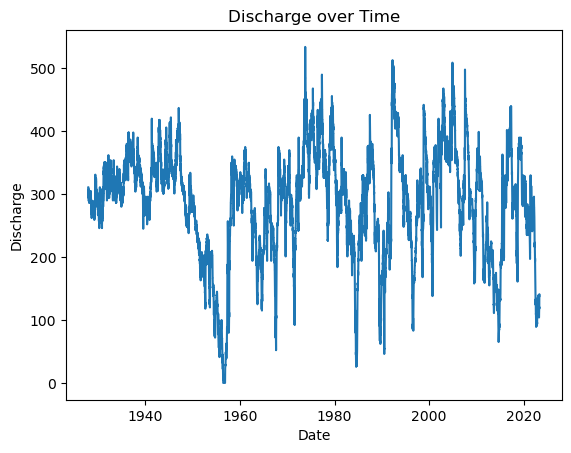

In [5]:
#Plot Dischage over Time
plt.plot(a['Discharge'])
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Discharge over Time')
plt.show()

In [6]:
#Split the data into trainig and testing
train_data, test_data = train_test_split(a, test_size=0.3, shuffle=False, random_state=42)

In [7]:
#Scale the data in range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_sca = scaler.fit_transform(train_data[['Discharge']])
test_data_sca = scaler.transform(test_data[['Discharge']])

In [8]:
#Create a dataset in terms of batches with batch size of 10
Input_batch = 10
def pred_dataset(data, Input_batch):
    X, y = [], []
    for i in range(len(data) - Input_batch):
        X.append(data[i:i+Input_batch])
        y.append(data[i+Input_batch])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = pred_dataset(train_data_sca, Input_batch)
X_test, y_test = pred_dataset(test_data_sca, Input_batch)

In [9]:
#Create RNN LSTM Model
model = Sequential([
    LSTM(units=85, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=85),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=15, batch_size=25) #fitting the model

Epoch 1/15
975/975 [==============================] - 35s 27ms/step - loss: 0.0017
Epoch 2/15
975/975 [==============================] - 29s 30ms/step - loss: 2.3790e-04
Epoch 3/15
975/975 [==============================] - 29s 30ms/step - loss: 1.8082e-04
Epoch 4/15
975/975 [==============================] - 29s 30ms/step - loss: 1.1865e-04
Epoch 5/15
975/975 [==============================] - 29s 30ms/step - loss: 9.3956e-05
Epoch 6/15
975/975 [==============================] - 29s 30ms/step - loss: 6.8235e-05
Epoch 7/15
975/975 [==============================] - 29s 30ms/step - loss: 5.6691e-05
Epoch 8/15
975/975 [==============================] - 29s 30ms/step - loss: 5.4147e-05
Epoch 9/15
975/975 [==============================] - 29s 30ms/step - loss: 5.1397e-05
Epoch 10/15
975/975 [==============================] - 29s 30ms/step - loss: 4.9079e-05
Epoch 11/15
975/975 [==============================] - 29s 30ms/step - loss: 4.7647e-05
Epoch 12/15
975/975 [========================

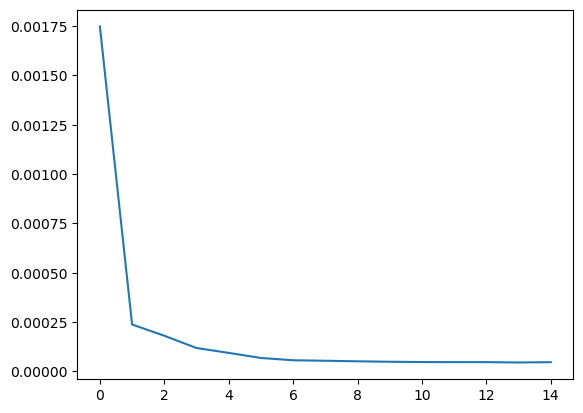

In [10]:
#Plot loss per epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 85)            29580     
                                                                 
 lstm_1 (LSTM)               (None, 85)                58140     
                                                                 
 dense (Dense)               (None, 1)                 86        
                                                                 
Total params: 87,806
Trainable params: 87,806
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Testing the model for test data
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_loss = np.mean(np.square(train_pred - y_train)) #calculate the loss of traning
test_loss = np.mean(np.square(test_pred - y_test)) #calculate the loss of testing

print(f'Train loss: {train_loss:}, Test loss: {test_loss:}')

327/327 [==============================] - 4s 12ms/step
Train loss: 3.8453623906146845e-05, Test loss: 2.8094732272253524e-05


In [13]:
#Transform the values from scaler to original form 
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
# Compute the root mean squared error for the test set
rmse = math.sqrt(mean_squared_error(y_test, test_pred))
print(f"Root Mean Squared Error: {rmse:}")

Root Mean Squared Error: 2.830438404573666


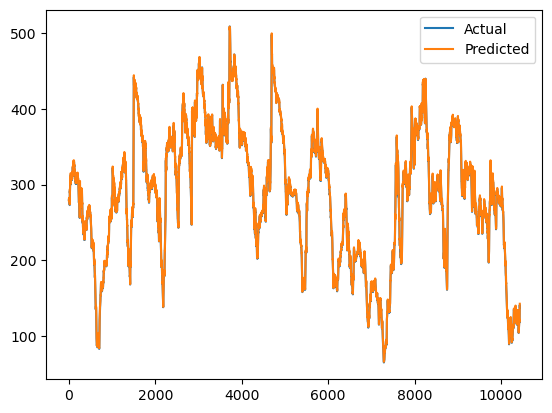

In [15]:
#Plot the actual vs predicted values 
plt.plot(y_test, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.legend()
plt.show()